# Ames Housing Price Predictor

The objective is to predict the sales price for each house (SalePrice variable)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
housing=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
housing_labels = housing['SalePrice'].copy()

In [3]:
train_len = len(housing)

In [4]:
print(housing.shape, test.shape)

(1460, 81) (1459, 80)


# 1. Data Cleaning

we merge train and test data to perform the cleaning step

In [5]:
concat_df = pd.concat([housing,test]).reset_index(drop=True)
concat_df = concat_df.drop('SalePrice',axis=1)
concat_df.shape

(2919, 80)

In [6]:
#concat_df.info()

## 1.1 Missing data

In [7]:
concat_df.isna().sum()[concat_df.isna().sum()>0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

Most of the features seem to have missing values, but they are actually 'None' values

In [8]:
concat_df['PoolQC'] = concat_df['PoolQC'].fillna('None')
concat_df['MiscFeature'] = concat_df['MiscFeature'].fillna('None')
concat_df['Alley'] = concat_df['Alley'].fillna('None')
concat_df['Fence'] = concat_df['Fence'].fillna('None')
concat_df['FireplaceQu'] = concat_df['FireplaceQu'].fillna('None')
concat_df['MasVnrType'] = concat_df['MasVnrType'].fillna('None')

concat_df['GarageCond'] = concat_df['GarageCond'].fillna('None')
concat_df['GarageQual'] = concat_df['GarageQual'].fillna('None')
concat_df['GarageFinish'] = concat_df['GarageFinish'].fillna('None')
concat_df['GarageType'] = concat_df['GarageType'].fillna('None')

concat_df['BsmtQual'] = concat_df['BsmtQual'].fillna('None')
concat_df['BsmtCond'] = concat_df['BsmtCond'].fillna('None')
concat_df['BsmtExposure'] = concat_df['BsmtExposure'].fillna('None')
concat_df['BsmtFinType1'] = concat_df['BsmtFinType1'].fillna('None')
concat_df['BsmtFinType2'] = concat_df['BsmtFinType2'].fillna('None')

concat_df['Functional'] = concat_df['Functional'].fillna('Typ')  #Typical functionality

In [9]:
#concat_df[concat_df['MasVnrArea'].isna()][['MasVnrArea','MasVnrType']]
concat_df['MasVnrArea'] = concat_df['MasVnrArea'].fillna(0) #MasVnrArea NaN ocurrs when MasVnrType is None
                                                            
concat_df['BsmtFinSF1'] = concat_df['BsmtFinSF1'].fillna(0)
concat_df['BsmtFinSF2'] = concat_df['BsmtFinSF2'].fillna(0)
concat_df['BsmtUnfSF'] = concat_df['BsmtUnfSF'].fillna(0)
concat_df['TotalBsmtSF'] = concat_df['TotalBsmtSF'].fillna(0)
concat_df['BsmtFullBath'] = concat_df['BsmtFullBath'].fillna(0)
concat_df['BsmtHalfBath'] = concat_df['BsmtHalfBath'].fillna(0)
concat_df['GarageYrBlt'] = concat_df['GarageYrBlt'].fillna(0)
concat_df['GarageArea'] = concat_df['GarageArea'].fillna(0)
concat_df['GarageCars'] = concat_df['GarageCars'].fillna(0)

The <b>MSZoning</b> missing data is from 'IDOTRR' & 'Mitchel' Neighborhoods, so we impute the most frecuent classification zone (RM & RL respectively):  

In [10]:
concat_df.groupby(['Neighborhood','MSZoning']).count().loc[['IDOTRR','Mitchel']].sort_values(['Neighborhood','Id'], ascending=False)

Id  MSSubClass  LotFrontage  LotArea  Street  Alley  \
Neighborhood MSZoning                                                         
Mitchel      RL        104         104           81      104     104    104   
             RM          9           9            8        9       9      9   
IDOTRR       RM         68          68           63       68      68     68   
             C (all)    22          22           22       22      22     22   

                       LotShape  LandContour  Utilities  LotConfig  ...  \
Neighborhood MSZoning                                               ...   
Mitchel      RL             104          104        104        104  ...   
             RM               9            9          9          9  ...   
IDOTRR       RM              68           68         68         68  ...   
             C (all)         22           22         22         22  ...   

                       ScreenPorch  PoolArea  PoolQC  Fence  MiscFeature  \
Neighborhood MSZoning                                                      
Mitchel      RL                104       104     104    104          104   
             RM                  9         9       9      9            9   
IDOTRR       RM                 68        68      68     68           68   
             C (all)            22        22      22     22           22   

                       MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Neighborhood MSZoning                                                    
Mitchel      RL            104     104     104       104            104  
             RM              9       9       9         9              9  
IDOTRR       RM             68      68      68        68             68  
             C (all)        22      22      22        22             22  

[4 rows x 78 columns]

In [11]:
concat_df.loc[concat_df['MSZoning'].isna(),'MSZoning'] = concat_df['Neighborhood'].map({'IDOTRR':'RM','Mitchel':'RL'})

The <b>Exterior1st & Exterior2nd</b> missing data correspond to the same instance, so we impute it based on the most common value according to the house quality ('OverallQual'= 5), i.e 'MetalSd'

In [12]:
#concat_df[concat_df['Exterior1st'].isna()|concat_df['Exterior2nd'].isna()]['OverallQual']  #OverallQual = 5

concat_df.groupby(['OverallQual','Exterior1st']).count().loc[5].sort_values('LotFrontage',ascending=False).head(1) #same outcome for 'Exterior2nd'

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Exterior1st,,,,,,,,,,,,,,,,,,,,,
MetalSd,176,176,176,156,176,176,176,176,176,176,...,176,176,176,176,176,176,176,176,176,176


In [13]:
concat_df[['Exterior1st','Exterior2nd']] = concat_df[['Exterior1st','Exterior2nd']].fillna('MetalSd')

<b>Electrical & KitchenQual & SaleType</b> features only have 1 missing value and it will be imputed with the most frecuent value.

In [14]:
concat_df['Electrical'] = concat_df['Electrical'].fillna(concat_df['Electrical'].mode()[0])
concat_df['KitchenQual'] = concat_df['KitchenQual'].fillna(concat_df['KitchenQual'].mode()[0])
concat_df['SaleType'] = concat_df['SaleType'].fillna(concat_df['SaleType'].mode()[0])

The <b>Utilities</b> feature only contains "AllPub" values, so it won't help to train the model. Therefore, it will be dropped.

In [15]:
concat_df = concat_df.drop('Utilities', axis=1)

In order to imput <b>LotFrontage</b>, we explore the alternatives of doing so based on Neighborhood and Building type. Preferring the first option since the houses median according to their neighborhood should be more representative (median instead of mean due to the presence of outliers).

<AxesSubplot:xlabel='BldgType', ylabel='LotFrontage'>

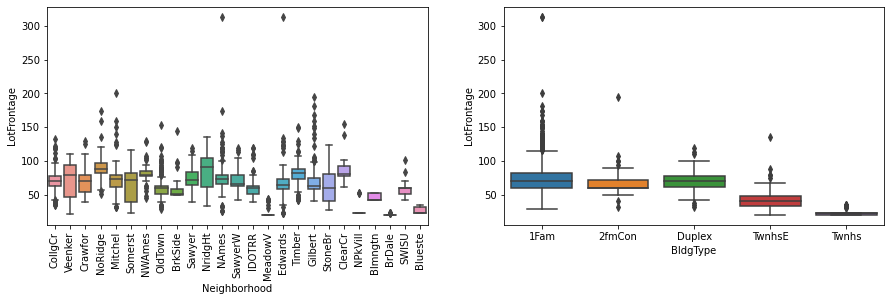

In [16]:
f,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].tick_params(axis='x', rotation=90)
sns.boxplot(data=concat_df, x='Neighborhood', y='LotFrontage',ax=ax[0])
sns.boxplot(data=concat_df, x='BldgType', y='LotFrontage',ax=ax[1]);

But before imputing, We can clearly observe 2 <b>Outliers</b> away from the rest of the instances, which are more evident when we plot the 'LotFrontage' against the target value 'SalePrice'

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

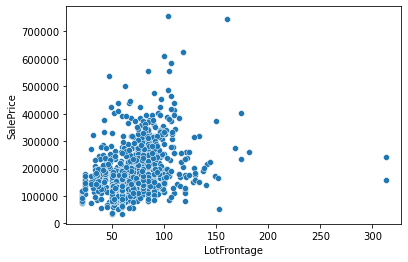

In [17]:
sns.scatterplot(x=concat_df.loc[:train_len,'LotFrontage'],y=housing_labels);

So we proceed to <b>drop</b> both instances (both from trainig data so we modify train_len & housing_labels too)

In [18]:
outlyr_idx = concat_df[concat_df['LotFrontage']>300].index
concat_df = concat_df.drop(outlyr_idx).reset_index(drop=True)
housing_labels = housing_labels.drop(outlyr_idx).reset_index(drop=True)
train_len = train_len - 2

and then we proceed to impute <b>LotFrontage</b> missing data

In [19]:
neigh_median = concat_df.groupby('Neighborhood')['LotFrontage'].mean()
concat_df.loc[concat_df['LotFrontage'].isna(),'LotFrontage']=concat_df['Neighborhood'].map(neigh_median)

## 1.2 Data type correction

<b>MSSubClass</b> & <b>MoSold</b> as categorical variables

In [20]:
concat_df['MSSubClass'] = concat_df['MSSubClass'].astype(str)
concat_df['MoSold'] = concat_df['MoSold'].astype(str)

# 2. EDA

In [21]:
housing = pd.concat([concat_df[:train_len],housing_labels],axis=1)
test = concat_df[train_len:]

In [22]:
num_atr=housing._get_numeric_data().columns
print(len(num_atr),num_atr)

36 Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'SalePrice'],
      dtype='object')


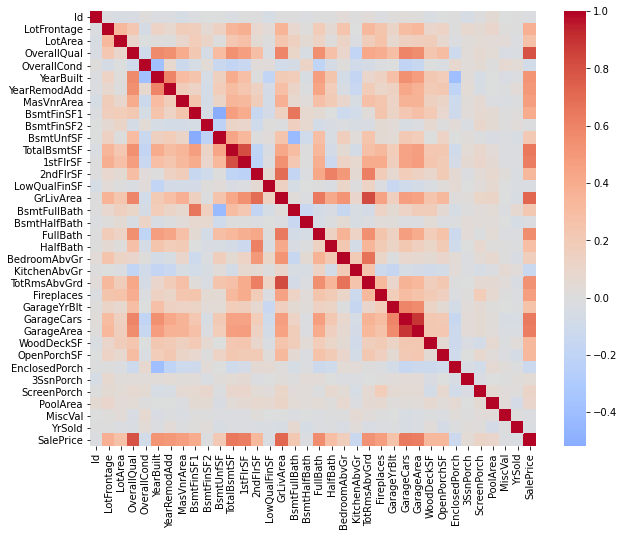

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(housing.corr(), center=0, cmap='coolwarm');

this way we can see some logical correlations between variables such as garage area and garage cars, and confirm others such as year built and Overall quality. To understand how they could help us with our price prediction, we will study the correlation with our target variable Sale Price

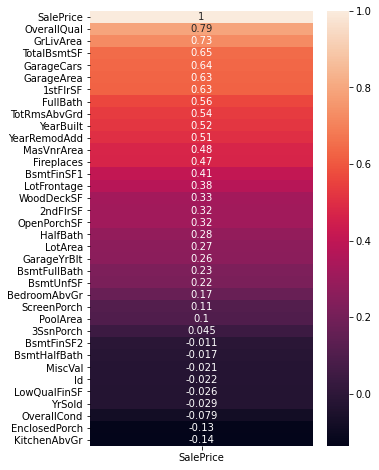

In [24]:
plt.figure(figsize=(5,8))
sns.heatmap(housing.corr()[['SalePrice']].sort_values('SalePrice',ascending=False), annot=True);

There are several variables with corr above 0.5 so we will take a closer loot at 6 of them, understanding that some are highly correlated (for instance GarageArea & GarageCars)

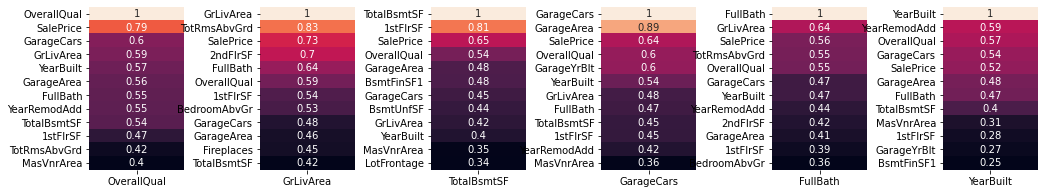

In [25]:
f, ax = plt.subplots(1,6, figsize=(17,3))
plt.subplots_adjust(wspace=0.8)
#plt.figure(figsize=(3,8))
sns.heatmap(housing.corr()[['OverallQual']].sort_values('OverallQual',ascending=False)[:12], annot=True, ax=ax[0], cbar=False);
sns.heatmap(housing.corr()[['GrLivArea']].sort_values('GrLivArea',ascending=False)[:12], annot=True, ax=ax[1], cbar=False);
sns.heatmap(housing.corr()[['TotalBsmtSF']].sort_values('TotalBsmtSF',ascending=False)[:12], annot=True, ax=ax[2], cbar=False);
sns.heatmap(housing.corr()[['GarageCars']].sort_values('GarageCars',ascending=False)[:12], annot=True, ax=ax[3], cbar=False);
sns.heatmap(housing.corr()[['FullBath']].sort_values('FullBath',ascending=False)[:12], annot=True, ax=ax[4], cbar=False);
sns.heatmap(housing.corr()[['YearBuilt']].sort_values('YearBuilt',ascending=False)[:12], annot=True, ax=ax[5], cbar=False);


we can see a strong correlation between square feet and SalePrice, so we should create "TotalHouseSF" variable (we will address this later, feature eng part), adding 'GrLivArea' and 'TotalBsmtSF' (Garage Area will be considered on its own).

Finally it is always useful to visually check the scatterplot distribution of each variable according to Sale Price. At the end we can observe how SalePrice is right skewed, we will tackle that in the feature engeeniering part.

In [26]:
#sns.pairplot(housing[num_atr],y_vars=num_atr,x_vars='SalePrice',aspect=1.5,plot_kws={'alpha': 0.4});

# 3. Feature Engeeniering

## 3.1 Adding TotalHouseSF:

As we saw before, a new variable with the total house square feet could be a great predictor, so we proceed to create it:

In [27]:
concat_df['TotalHouseSF'] = concat_df['GrLivArea'] + concat_df['TotalBsmtSF']

## 3.2 Skewed Features:

The skewness is very relevant for linear models, so we will start analyzing the SalePrice distribution to see how symmetric it is:

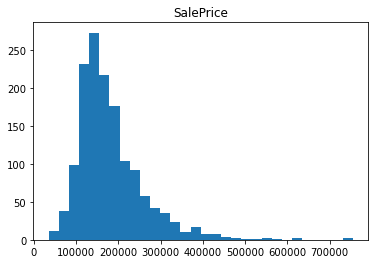

In [28]:
plt.title('SalePrice')
housing_labels.hist(bins=30,grid=False);

As we can see, it is right skewed, and since linear models work better with evenly distributed data, we can center it through a logarithmic transformation to approximate to a more symmetric distribution.

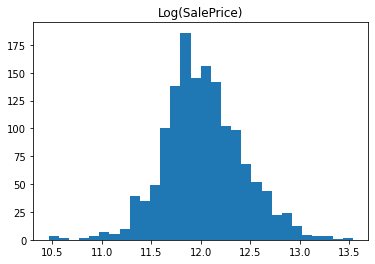

In [29]:
plt.title('Log(SalePrice)')
np.log(housing_labels).hist(bins=30,grid=False);

In [30]:
housing_labels = np.log(housing_labels)

We can extend this to the features, so we will transform them when unbiased skewness is over 0.65 (0.5 is a rule of thumb for moderate skewness, so will give a little more margin).
(cons:GarageYrBlt is skewed due to the high number of 0)

In [31]:
num_atr = concat_df.select_dtypes(exclude='object').columns
concat_df[num_atr].skew()[abs(concat_df.skew())>0.65].sort_values(ascending=False)

MiscVal          21.950962
PoolArea         17.697766
LotArea          13.064929
LowQualFinSF     12.090757
3SsnPorch        11.377932
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004404
ScreenPorch       3.947131
BsmtHalfBath      3.932018
MasVnrArea        2.618126
OpenPorchSF       2.540137
WoodDeckSF        1.844187
1stFlrSF          1.283349
GrLivArea         1.129981
TotalHouseSF      1.084866
BsmtFinSF1        0.991938
BsmtUnfSF         0.919016
2ndFlrSF          0.862829
TotRmsAbvGrd      0.753015
Fireplaces        0.725651
TotalBsmtSF       0.697775
HalfBath          0.695429
GarageYrBlt      -3.906636
dtype: float64

Since we have some feature values equal to cero, we transform the variables using <b>natural logarithmic(x+1)</b>, to avoid having negative infinite values. 

In [32]:
skw_feat = concat_df[num_atr].skew()[concat_df.skew()>0.65].index
concat_df[skw_feat] = np.log(concat_df[skw_feat]+1)

In [33]:
housing = pd.concat([concat_df[:train_len],housing_labels],axis=1)
test = concat_df[train_len:]

Finally we explore the correlation with SalePrice again, where most of the variables improve their coefficient and where we can observe that the added feature 'TotalHouseSF' has a high correlation with the target 

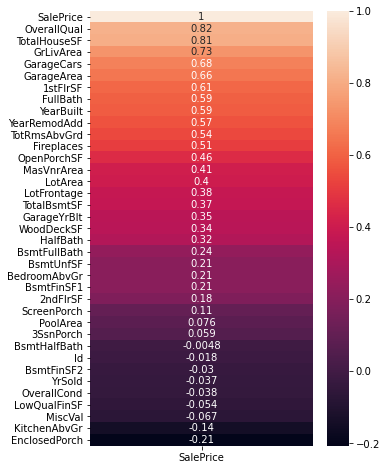

In [34]:
plt.figure(figsize=(5,8))
sns.heatmap(housing.corr()[['SalePrice']].sort_values('SalePrice',ascending=False), annot=True);

In [35]:
housing = housing.drop('SalePrice', axis=1)

## 3.3 Numerical Features Pipeline:

Finally we add a Pipeline to apply standardization on the features

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline([('scaler',StandardScaler())
                #,('poli_tranf',PolynomialFeatures(degree=2,include_bias=False)) #after exploring models, i decided not to use polynomial transformation
                ])

## 3.4 Categorical Features:

In [37]:
num_atr = housing.select_dtypes(exclude='object').columns
cat_atr = housing.select_dtypes(include='object').columns

Now we will complement the Pipeline Above and include OneHotEncoder for categorical variables. Since we are using Models with regularization later, we won't drop any feature, because doing so would change the optimization problem and therefore the optimal.

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

full_pipe = ColumnTransformer([
        ("num",pipe,num_atr),
        ("cat",OneHotEncoder(handle_unknown='ignore',drop=None),cat_atr)  #we don't drop the first cat per feature ONLY in regularized models 
    ])

In [39]:
housing_prepared = full_pipe.fit_transform(housing)

In [40]:
cat_names = full_pipe.named_transformers_['cat'].get_feature_names()
tot_column_names=list(num_atr)+list(cat_names)

# 4. Training Model

We will use RMSE as our cost function, this will be calculated using cross validation to leverage the amount of data available to train

In [41]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X,y):
    scores = cross_val_score(model,X, y, scoring='neg_root_mean_squared_error',cv=10)
    return(scores)

def display_cv_score(s):
    print(f'  mean:{-s.mean()}')
    print(f'  std:{s.std()}')

## 4.1 Base Models

### Linear, Ridge, Lasso and ElasticNet Regresion

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

lm = LinearRegression()
rm = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1,max_iter=2000)
elastic_net = ElasticNet(alpha=0.1,l1_ratio=0.5,max_iter=2000)

In [43]:
print('Linear reg:')
display_cv_score(rmse_cv(lm,housing_prepared, housing_labels))

print('Ridge reg:')
display_cv_score(rmse_cv(rm,housing_prepared, housing_labels))

print('Lasso reg:')
display_cv_score(rmse_cv(lasso,housing_prepared, housing_labels))

print('Elastic Net reg:')
display_cv_score(rmse_cv(elastic_net,housing_prepared, housing_labels))

Linear reg:
  mean:0.13592845596099384
  std:0.035853427569899766
Ridge reg:
  mean:0.12337524578609513
  std:0.02020068529388576
Lasso reg:
  mean:0.20570135513622692
  std:0.01713450160378756
Elastic Net reg:
  mean:0.16694719406199576
  std:0.014202910513279581


## 4.2 Fine Tune model parameters

## 4.2.1 Fine Tune model without feature selection

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
def grid(model,X,y,params,results):
    mod = GridSearchCV(model,params,cv=10,scoring='neg_root_mean_squared_error')
    mod.fit(X,y)
    df = pd.DataFrame(mod.cv_results_)[results].sort_values('mean_test_score')
    return(df)

### Ridge

In [46]:
alphas_param = {'alpha':[0.005,0.05,0.1,0.5,1,5,10,15,20,30,50,75]}
ridge = grid(rm,housing_prepared,housing_labels,alphas_param,['param_alpha','mean_test_score'])
ridge

,param_alpha,mean_test_score
0,0.005,-0.124519
1,0.05,-0.123945
2,0.1,-0.123375
3,0.5,-0.120009
4,1,-0.117911
11,75,-0.116575
10,50,-0.115545
5,5,-0.115031
9,30,-0.114787
8,20,-0.114410


<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

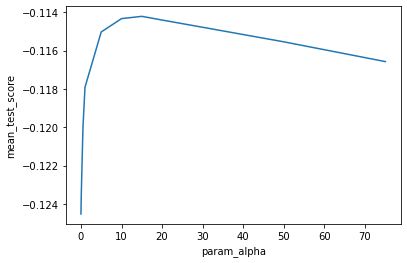

In [47]:
sns.lineplot(data=ridge, x='param_alpha',y='mean_test_score');

### Lasso

In [48]:
alphas_param = {'alpha':[0.0001,0.001,0.005,0.01,0.05]}
grid(lasso, housing_prepared,housing_labels, alphas_param,['param_alpha','mean_test_score'])

,param_alpha,mean_test_score
4,0.05,-0.166702
3,0.01,-0.133161
2,0.005,-0.128432
0,0.0001,-0.118350
1,0.001,-0.113369


One of the adventages of using lasso is that it will drop some features, we can take adventage of this and explore if the models improve their prediction power

In [49]:
lasso = Lasso(alpha=0.001)
lasso.fit(housing_prepared, housing_labels);

In [50]:
pd.Series(lasso.coef_,index=tot_column_names)[lasso.coef_!=0]

Id            -0.001661
LotFrontage    0.001010
LotArea        0.040393
OverallQual    0.073737
OverallCond    0.051077
                 ...   
x41_7          0.003420
x42_New        0.034004
x42_WD        -0.011740
x43_Abnorml   -0.048169
x43_Normal     0.010283
Length: 85, dtype: float64

As we can see only 85 features were selected using Lasso best param (alpha=0.001). We will use these features to retrain the models

### ElasticNet

In [51]:
eparams = {'alpha':[0.0007,0.001,0.003],'l1_ratio':[0.1,0.4,0.5,0.6,0.7,0.8]}
grid(elastic_net, housing_prepared,housing_labels, eparams,['param_alpha','param_l1_ratio','mean_test_score'])

,param_alpha,param_l1_ratio,mean_test_score
17,0.003,0.8,-0.121062
16,0.003,0.7,-0.119966
15,0.003,0.6,-0.118632
14,0.003,0.5,-0.116893
0,0.0007,0.1,-0.115825
13,0.003,0.4,-0.115136
6,0.001,0.1,-0.114583
1,0.0007,0.4,-0.112944
12,0.003,0.1,-0.112838
2,0.0007,0.5,-0.112769


In [52]:
elastic_net=ElasticNet(alpha=0.001,l1_ratio=0.7)
elastic_net.fit(housing_prepared,housing_labels)
pd.Series(tot_column_names)[elastic_net.coef_!=0]

0               Id
1      LotFrontage
2          LotArea
3      OverallQual
4      OverallCond
          ...     
308          x41_7
317        x42_New
319         x42_WD
320    x43_Abnorml
324     x43_Normal
Length: 98, dtype: object

In this case 98 features were selected using ElasticNet best params. We will explore these features to retrain the models as with Lasso.

## 4.2.2 Fine Tune model with feature selection (Lasso & Enet selection )

All the models performed best with the lasso selected features, so we only show those models in this section (and comment the Enet params)

In [53]:
housing_prepared_ft_lasso = housing_prepared[:,lasso.coef_!=0]
#housing_prepared_ft_enet = housing_prepared[:,elastic_net.coef_!=0]

### Retrain Linear Regression

In [54]:
display_cv_score(rmse_cv(lm,housing_prepared_ft_lasso,housing_labels))
#display_cv_score(rmse_cv(lm,housing_prepared_ft_enet,housing_labels))

  mean:0.10865472868078536
  std:0.02090207725062274


### Retrain Ridge

In [55]:
alphas_param = {'alpha':[0.005,0.05,0.1,0.5,1,5,10,15,20,30,50,75]}
grid(rm,housing_prepared_ft_lasso,housing_labels,alphas_param,['param_alpha','mean_test_score'])

#alphas_param = {'alpha':[0.005,0.05,0.1,0.5,1,5,10,15,20,30,50,75]}
#grid(rm,housing_prepared_ft_enet,housing_labels,alphas_param,['param_alpha','mean_test_score'])

,param_alpha,mean_test_score
11,75,-0.115124
10,50,-0.113538
9,30,-0.111990
8,20,-0.110998
7,15,-0.110449
6,10,-0.109742
5,5,-0.109041
0,0.005,-0.108664
1,0.05,-0.108653
2,0.1,-0.108650


### Retrain Lasso 

In [56]:
alphas_param = {'alpha':[0.0001,0.001,0.005,0.01,0.05]}
grid(lasso, housing_prepared_ft_lasso,housing_labels, alphas_param,['param_alpha','mean_test_score'])

#alphas_param = {'alpha':[0.0001,0.001,0.005,0.01,0.05]}
#grid(lasso, housing_prepared_ft_enet,housing_labels, alphas_param,['param_alpha','mean_test_score'])

,param_alpha,mean_test_score
4,0.05,-0.166702
3,0.01,-0.133161
2,0.005,-0.128429
1,0.001,-0.112805
0,0.0001,-0.108597


### Retrain ElasticNet 

In [57]:
eparams = {'alpha':[0.0007,0.001,0.003],'l1_ratio':[0.1,0.4,0.5,0.6,0.7]}
grid(elastic_net, housing_prepared_ft_lasso,housing_labels, eparams,['param_alpha','param_l1_ratio','mean_test_score'])

#eparams = {'alpha':[0.0007,0.001,0.003],'l1_ratio':[0.1,0.4,0.5,0.6,0.7,0.8]}
#grid(elastic_net, housing_prepared_ft_enet,housing_labels, eparams,['param_alpha','param_l1_ratio','mean_test_score'])

,param_alpha,param_l1_ratio,mean_test_score
14,0.003,0.7,-0.119746
13,0.003,0.6,-0.118374
12,0.003,0.5,-0.116604
11,0.003,0.4,-0.114731
9,0.001,0.7,-0.110962
8,0.001,0.6,-0.110418
7,0.001,0.5,-0.109947
4,0.0007,0.7,-0.109804
10,0.003,0.1,-0.109689
6,0.001,0.4,-0.109537


# 5. Final Model

Finally we select the best model according to CV RMSE, The Ridge regression with alpha equivalent to 0.5 and 85 features.

In [58]:
Ridge_model = Ridge(alpha=0.5)
Ridge_model.fit(housing_prepared_ft_lasso,housing_labels)

Ridge(alpha=0.5)

In [59]:
X_test = full_pipe.transform(test)[:,lasso.coef_!=0]

In [60]:
submission=pd.DataFrame()
submission['Id'] = test['Id']
submission['SalePrice']=np.exp(Ridge_model.predict(X_test))

In [61]:
submission.to_csv('submission.csv',index=False)